In [2]:
import numpy as np
import nolds
from matplotlib import pyplot as plt
from numpy import linalg as la
import os
from scipy import stats
from scipy import spatial as sp
from scipy import sparse
from sklearn import linear_model
from scipy import linalg as sla

import lyapynov as le

import pandas as pd
import networkx as nx

import SystemsSolved as s
import Methods as m

import Sparse_Reservoir_Computing as rc

import RecurrencePlotsCode as rp


import multiprocess as mp

In [3]:
mu_pts = np.linspace(0, 0.1, 11)
mu_pts

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [ ]:
#Saving intial conditations to file 
for i in range(0, len(mu_pts)):
    mu = mu_pts[i]
    nu = 0.02

    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
    Ry_ts = Ry.solve(t0 = 0, tFinal = 5000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)

    #Splits ts and removes transient time 
    A0 = Ry_ts[0:3, :] 
    B0 = Ry_ts[3:6, :] 

    T = 5000; N_s = 100
    rngA = np.random.default_rng(seed=4090)
    indexA = rngA.choice(T, N_s, replace=False, shuffle=True)

    IC_A = A0[:, indexA]

    rngB = np.random.default_rng(seed=2025)
    indexB = rngB.choice(T, N_s, replace=False, shuffle=True)

    IC_A = A0[:, indexA]
    IC_B = B0[:, indexB]

    RS_stats_df = pd.DataFrame(IC_A)
    RS_stats_df.to_csv("OutputData\\IdealSurrogate_IC\\A_"+str(mu_pts[i])+".csv")

    RS_stats_df = pd.DataFrame(IC_B)
    RS_stats_df.to_csv("OutputData\\IdealSurrogate_IC\\B_"+str(mu_pts[i])+".csv")
    print(i)




0
1
2
3
4
5
6
7
8
9
10


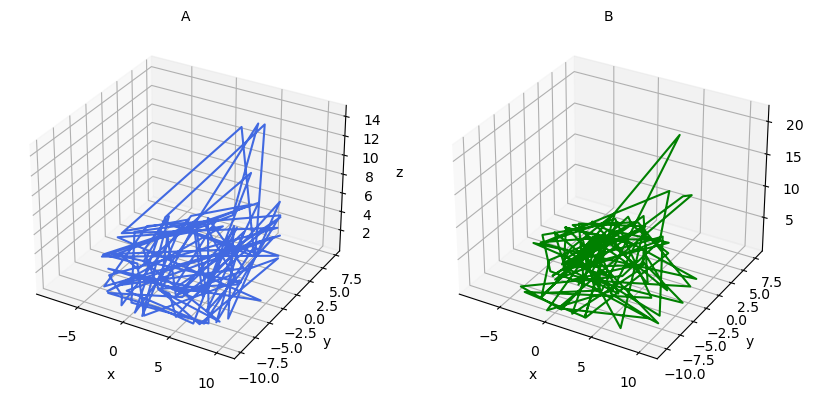

In [37]:
p = m.plot3D(cols=2, rows=1)
p.plot3D(IC_A, plotNum = 1, title = "A")
p.plot3D(IC_B, plotNum = 2, title = "B")

#### Using i.c. to get surrogates

In [ ]:
IC_A_csv = np.array(pd.read_csv("OutputData\\IdealSurrogate_IC\\A_"+str(0.0)+".csv"))
IC_B_csv = np.array(pd.read_csv("OutputData\\IdealSurrogate_IC\\B_"+str(0.0)+".csv"))

array([-8.21141812,  1.31379464,  0.01452713])

In [18]:
class genSurrogates():
    def __init__(self, file = "OutputData\\IdealSurrogate_IC\\"):
        self.file = file

    def load_ic(self, mu):
        IC_A_csv = np.array(pd.read_csv(self.file+"A_"+str(mu)+".csv"))
        IC_B_csv = np.array(pd.read_csv(self.file+"B_"+str(mu)+".csv"))

        return np.array(IC_A_csv), np.array(IC_B_csv)
    

    def Rossler_params(self, mu = 0, nu = 0.02, a = 0.2, b = 0.2, c =5.7, T = 50, dt = 0.01, t0 = 0):
        self.Ry = s.yCoupledRossler(a = a, b = b, c = c, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
        self.T = T; self.dt = dt; self.t0 = t0

    
    def gen_Coupled_Rossler(self, ic_A, ic_B):
         R = self.Ry.solve(t0 = self.t0, tFinal = self.T, x0_1 = ic_A, x0_2 = ic_B, dt = self.dt)
         return R
        


    

In [19]:
gS = genSurrogates()
np.array(gS.load_ic(mu = 0.0))

array([[[ 0.00000000e+00, -8.21141812e+00, -3.78691153e+00,
         -3.42248093e+00, -8.21637667e+00,  1.03285289e+01,
          7.90078846e-02, -4.05169982e+00,  2.31206397e+00,
          2.35365740e+00,  7.87450352e+00,  9.77854780e+00,
         -6.81014295e+00, -4.52622368e+00,  1.00641520e+01,
         -2.26460205e+00,  6.96740844e+00,  4.75653219e+00,
          1.04485902e+01, -7.61733024e+00,  4.45209197e+00,
          6.11130476e+00,  7.92064677e+00, -3.23752736e+00,
          5.61249586e+00, -2.28406509e+00,  7.31991978e+00,
         -7.90276407e-01, -7.31434611e+00, -2.31162058e+00,
         -7.71965805e+00, -3.94583483e+00,  1.39476166e+00,
          6.29006546e+00,  6.60231977e+00, -7.04048018e+00,
          4.21749134e+00,  3.82670612e+00, -2.52351451e+00,
         -3.81613825e+00, -1.45484230e-01, -4.67971308e+00,
         -3.61626969e+00,  8.10162786e+00,  3.55808625e-01,
         -4.67113776e+00, -5.89061403e+00,  1.28141480e+00,
         -3.33808398e+00,  3.36718415e+0

In [20]:
#Setting time for real trajectories
tStart = 700
tEnd = 800
dt = 0.01
iStart = int(tStart/dt) #Discarding beginning of time series 
iEnd = int(tEnd/dt) 

In [21]:
#Generates surrogates and then computes statistic 
gS = genSurrogates()
for i in range(0, len(mu_pts)):
        mu = mu_pts[i]; nu = 0.02
        N_s = 100
        

        params1 = []
        #N_s = ic_A.shape[1]
        #generate surrogates
        ic_A, ic_B = gS.load_ic(mu = mu)
        for i in range(0, N_s):
            temp = [ic_A[:, i], ic_B[:, i]]
            params1.append(temp)

        
            
        gS.Rossler_params( mu = mu, nu = nu, a = 0.2, b = 0.2, c =5.7, T = 100, dt = 0.01, t0 = 0)

        with mp.Pool(processes=6) as pool:
            results = pool.starmap_async(gS.gen_Coupled_Rossler, params1)
            Surrogates = results.get()

        #Generate Real Trajectory 
        Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
        Ry_ts = Ry.solve(t0 = 0, tFinal = 800, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)
        A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, :] 

        
  
        #Get in format to multiprocess
        params = []
        for i in range(0, N_s):
            a = [Surrogates[i], B0[:, iStart:iEnd]]
            params.append(a)

        #Comute Statistics 
        with mp.Pool(processes=6) as pool:
            results = pool.starmap_async(m.PSstat1, params)
            S_stats = results.get()

        RS_stats_df = pd.DataFrame(S_stats)
        RS_stats_df.to_csv("OutputData\\IdealSurrogate_IC\\S_dist_"+str(mu)+".csv")


In [10]:
#Known Test statisitcs
t_stats = pd.read_csv("OutputData\\0t_stat_Rossler.csv").to_numpy()[:, 1:3]

In [11]:
k = 0
str(mu_pts[k])

'0.0'

In [12]:
mu = mu_pts[k]

plt.hist(S_stat_1)
plt.axvline(t_stats[k][0],color='r')
k = k+1 
print(mu)


NameError: name 'S_stat_1' is not defined

In [13]:
pv = []
for i in range(0, mu_pts.shape[0]):
    S_stat_1 = np.array(pd.read_csv("OutputData\\IdealSurrogate_IC\\S_dist_"+str(mu_pts[i])+".csv"))[:, 1]
    a = np.array(np.where(S_stat_1 < t_stats[i][0])).shape[1]
    p = a / len(S_stat_1)
    pv.append(p)

In [14]:
pv

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

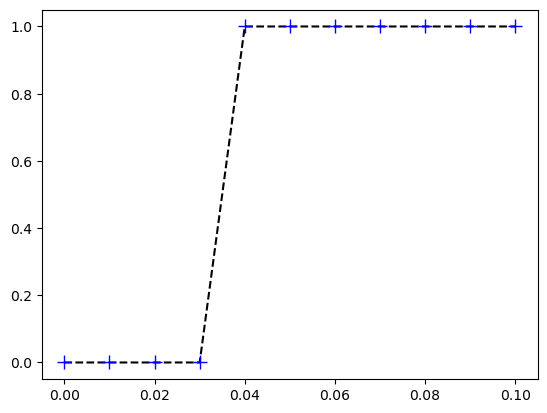

In [15]:
plt.plot(mu_pts, pv, marker="+", markersize=10, color='k', linestyle="--", markeredgecolor='b')

#### Getting t_statistics

In [ ]:
mu_

In [1]:
tStart = 700
tEnd = 800
dt = 0.01
iStart = int(tStart/dt) #Discarding beginning of time series 
iEnd = int(tEnd/dt) 


In [4]:
t_stats = []
for i in range(0, len(mu_pts)):
    mu = mu_pts[i]
    nu = 0.02
    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
    Ry_ts = Ry.solve(t0 = 0, tFinal = 800, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)
    A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, :] 
    
    a = m.PSstat1(A0[:, iStart:iEnd], B0[:, iStart:iEnd])
    t_stats.append([a, mu])


In [5]:
RS_stats_df = pd.DataFrame(t_stats)
RS_stats_df.to_csv("OutputData\\100_t_stat_Rossler.csv")

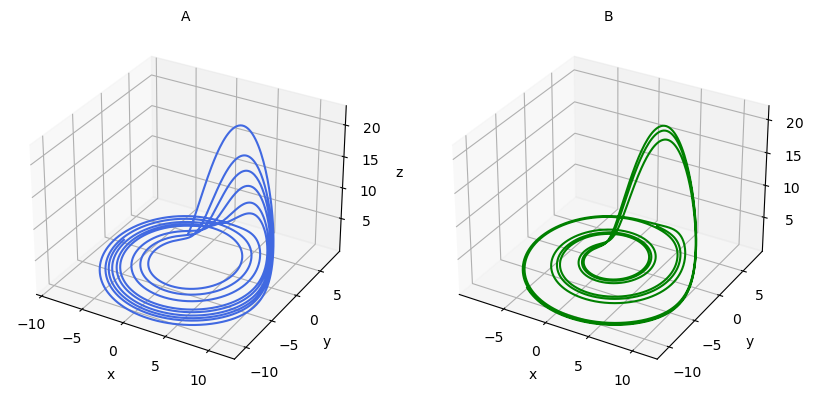

In [84]:
#Plot Two Time Series
p = m.plot3D(cols=2, rows=1)
p.plot3D(Surrogates[4], plotNum = 1, title = "A")
p.plot3D(B0[:, iStart:iEnd], plotNum = 2, title = "B")

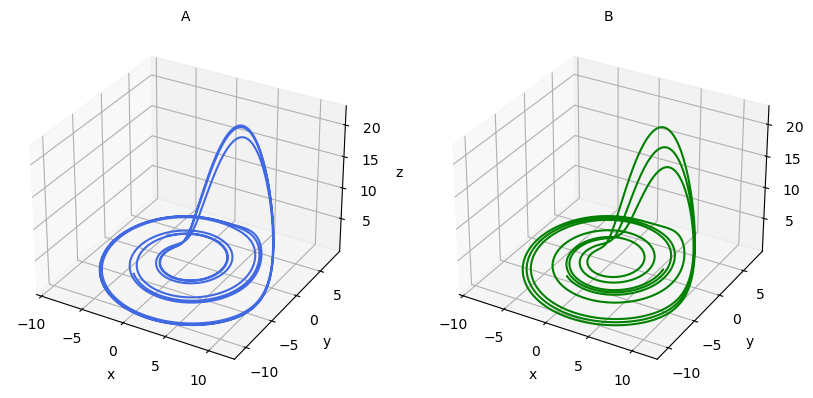

In [ ]:
#Plot Two Time Series
p = m.plot3D(cols=2, rows=1)
p.plot3D(A0[:, iStart:iEnd], plotNum = 1, title = "A")
p.plot3D(B0[:, iStart:iEnd], plotNum = 2, title = "B")

In [23]:
def getSurrogates(S, N = 10, Time = 100, dt = 0.01):
    L = int(Time/dt)
    SurrogatesA = []
    if (L*N > S.shape[1]):
        print("Insuffient Data to Generate Surrogates: Total length of surrogates exceeds time series provided")
        return 0
    else: 
        for i in range(0, N):
            SurrogatesA.append(S[:, (i*L):((i+1)*(L))])
            #SurrogatesB.append(S_B[:, (i*L):((i+1)*(L))])
        return SurrogatesA

In [24]:
class PScompute():
    def __init__(self, T = 100, N = 100, dt = 0.01, processes = 6):
        self.T = T
        self.N = N 
        self.dt = dt
        self.processes = processes
    
    def s_dist(self, Surrogates, Trajectory):
        SurrogatesA = getSurrogates(Surrogates, N=self.N, Time=self.T, dt = self.dt)
        params  = []
        for i in range(0, self.N):
            for j in range(0, self.N):
                if i != j: 
                    params.append([SurrogatesA[i], Trajectory]) 

        with mp.Pool(processes=self.processes) as pool:
            results = pool.starmap_async(m.PSstat1, params)
            L = results.get()

        return L
    
    def p_value(self, A0, B0, S):
        t_stat = m.PSstat1(A0, B0)
        a = np.array(np.where(S < t_stat)).shape[1]
        p = a / len(S)
        return p  

In [10]:
%%time
psc = PScompute(T = 50, N = 10, dt = 0.01, processes=6)
s_d = psc.s_dist(Surrogates=A0, Trajectory=B0[:, 70000:75000])

(array([18.,  9.,  9.,  9.,  0.,  9.,  9.,  0.,  9., 18.]),
 array([0.53072469, 0.55503098, 0.57933727, 0.60364356, 0.62794985,
        0.65225613, 0.67656242, 0.70086871, 0.725175  , 0.74948129,
        0.77378758]),
 <BarContainer object of 10 artists>)

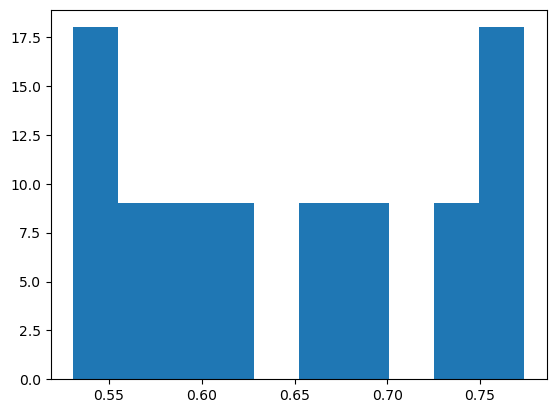

In [11]:
mu_pts = np.linspace(0, 0.1, 11)

In [25]:
psc = PScompute(T = 50, N = 10, dt = 0.01, processes=6)

In [26]:
S = []
for i in range(0, len(mu_pts)):
    mu = mu_pts[i]; nu = 0.02
    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
    Ry_ts = Ry.solve(t0 = 0, tFinal = 5000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)
    #Splits ts and removes transient time 
    A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, 70000:75000] 
    s_d = psc.s_dist(Surrogates=A0, Trajectory=B0)
    S.append(s_d)

    

In [27]:
U = []
for i in range(0, len(mu_pts)):
    mu = mu_pts[i]; nu = 0.02
    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = nu, mu1 = mu, nu2 = nu, mu2 = mu)
    Ry_ts = Ry.solve(t0 = 0, tFinal = 1000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)
    A0 = Ry_ts[0:3, 70000:75000]; B0 = Ry_ts[3:6, 70000:75000] 
    U.append([A0, B0])

In [28]:
with mp.Pool(processes=6) as pool:
    results = pool.starmap_async(m.PSstat1, U)
    T_stats = results.get()

In [135]:
mu_pts[16]

0.04

In [31]:
k = 0

In [42]:
S[0]

[0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.07613319791492597,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.13903299301881714,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.18177684681213446,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.21153506023381372,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.1499104517849153,
 0.2107046857383838

0.06
0.3


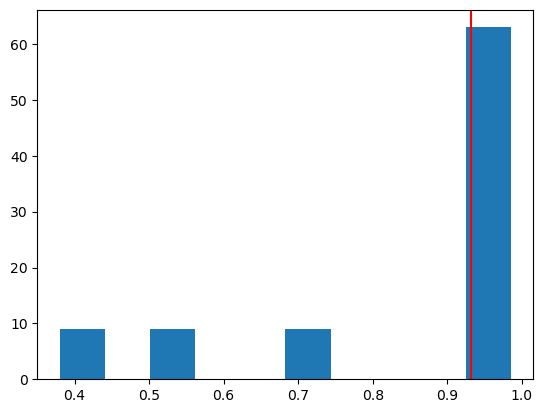

In [39]:
plt.hist(S[k])
plt.axvline(T_stats[k], color='r')
print(mu_pts[k]); print(pv[k])
k = k + 1




In [34]:
pv

[1.0, 0.4, 0.3, 0.3, 0.9, 1.0, 0.3, 1.0, 0.9, 1.0, 1.0]

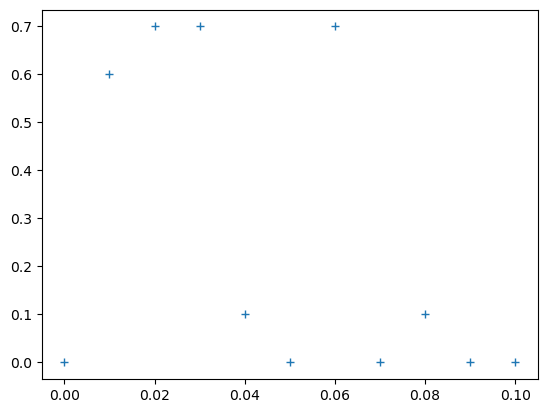

In [30]:
plt.plot(mu_pts, 1-np.array(pv), marker='+', linewidth=0)